# Multi-Task Learning for Food Ingredient Classification and Segmentation 
### Deep Learning for Visual Recognition

### 1. Dataset Exploration

#### 1.1 Load Dataset and Metadata
This section loads the `FoodSeg103` dataset and associated metadata.

In [12]:
from datasets import load_dataset
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import torch, torch.nn as nn
import torchvision.transforms as transforms
from tqdm import tqdm
from torchvision.models import list_models, get_model
from datasets import Dataset
from torch.utils.data import DataLoader
from collections import Counter

import pandas as pd
import json

ds = load_dataset("EduardoPacheco/FoodSeg103")

with open("data/idtolabel.json") as f:
    id2label = json.load(f)

num_classes = len(id2label)
label_to_idx = {v:k for k,v in id2label.items()}
label_list = list(label_to_idx.keys())

print(f"Number of classes: {num_classes}")
print(f"NUmber of train images: {len(ds['train'])}")
print(f"NUmber of validation images: {len(ds['validation'])}")

Number of classes: 104
NUmber of train images: 4983
NUmber of validation images: 2135


#### 1.2 Visualize Samples

In [13]:
print("Examples:")
df_examples = pd.DataFrame(ds['train'][:5])
df_examples

Examples:


image  \
0  <PIL.JpegImagePlugin.JpegImageFile image mode=...   
1  <PIL.JpegImagePlugin.JpegImageFile image mode=...   
2  <PIL.JpegImagePlugin.JpegImageFile image mode=...   
3  <PIL.JpegImagePlugin.JpegImageFile image mode=...   
4  <PIL.JpegImagePlugin.JpegImageFile image mode=...   

                                               label  \
0  <PIL.PngImagePlugin.PngImageFile image mode=L ...   
1  <PIL.PngImagePlugin.PngImageFile image mode=L ...   
2  <PIL.PngImagePlugin.PngImageFile image mode=L ...   
3  <PIL.PngImagePlugin.PngImageFile image mode=L ...   
4  <PIL.PngImagePlugin.PngImageFile image mode=L ...   

           classes_on_image  id  
0           [0, 48, 66, 90]   0  
1       [0, 52, 70, 82, 93]   1  
2               [0, 58, 67]   2  
3       [0, 48, 84, 85, 87]   3  
4  [0, 46, 84, 87, 96, 101]   4

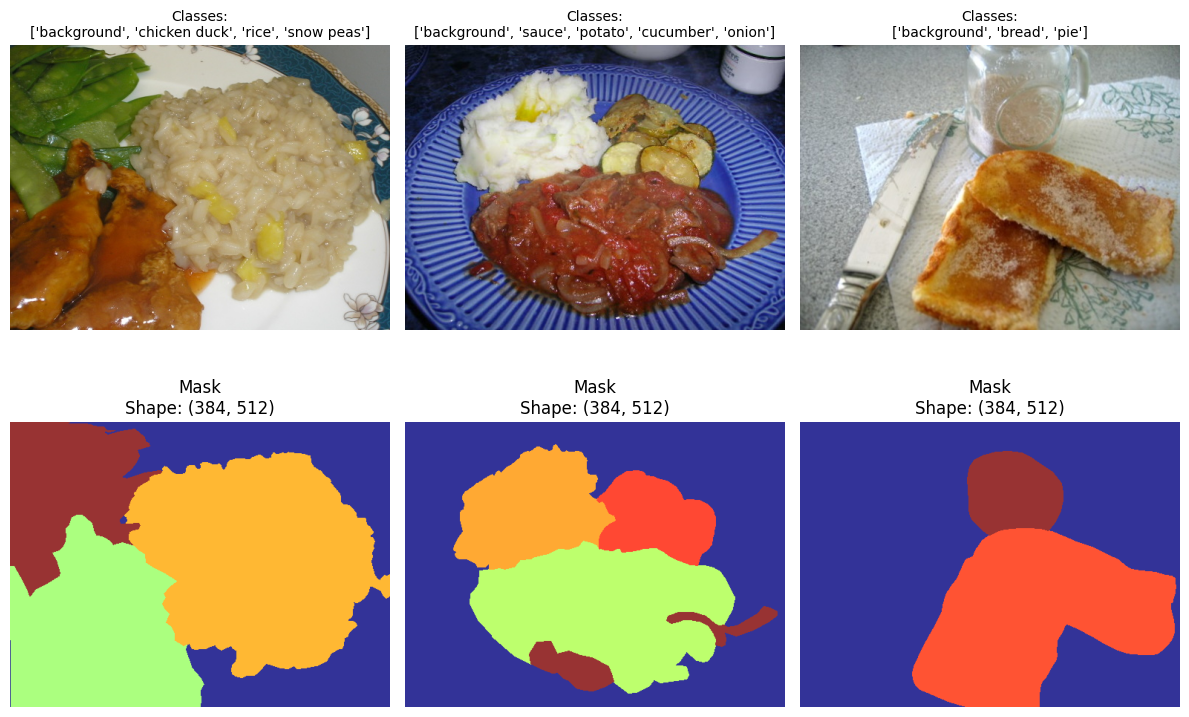

In [14]:
n_examples = 3
fig, axes = plt.subplots(2, n_examples, figsize=(4 * n_examples, 8))

for i in range(n_examples):
    example = ds["train"][i]
    img = example["image"]
    mask = np.array(example["label"])
    class_ids = example["classes_on_image"]
    class_names = [label_list[c] for c in class_ids]

    # IMAGE
    axes[0, i].imshow(img)
    # Show class names as a list, one per line, to avoid overlap
    axes[0, i].set_title(f"Classes:\n{class_names}", fontsize=10)
    axes[0, i].axis("off")

    # MASK
    axes[1, i].imshow(mask, cmap="jet", alpha=0.8)
    axes[1, i].set_title(f"Mask\nShape: {mask.shape}")
    axes[1, i].axis("off")

plt.tight_layout()
plt.show()


#### 1.3 Class Distribution Analysis

##### 1.3.1 Distribution Across Training Set
The dataset exhibits severe class imbalance, with many classes appearing in fewer than 50 images. This is expected to affect the classification branch significantly.

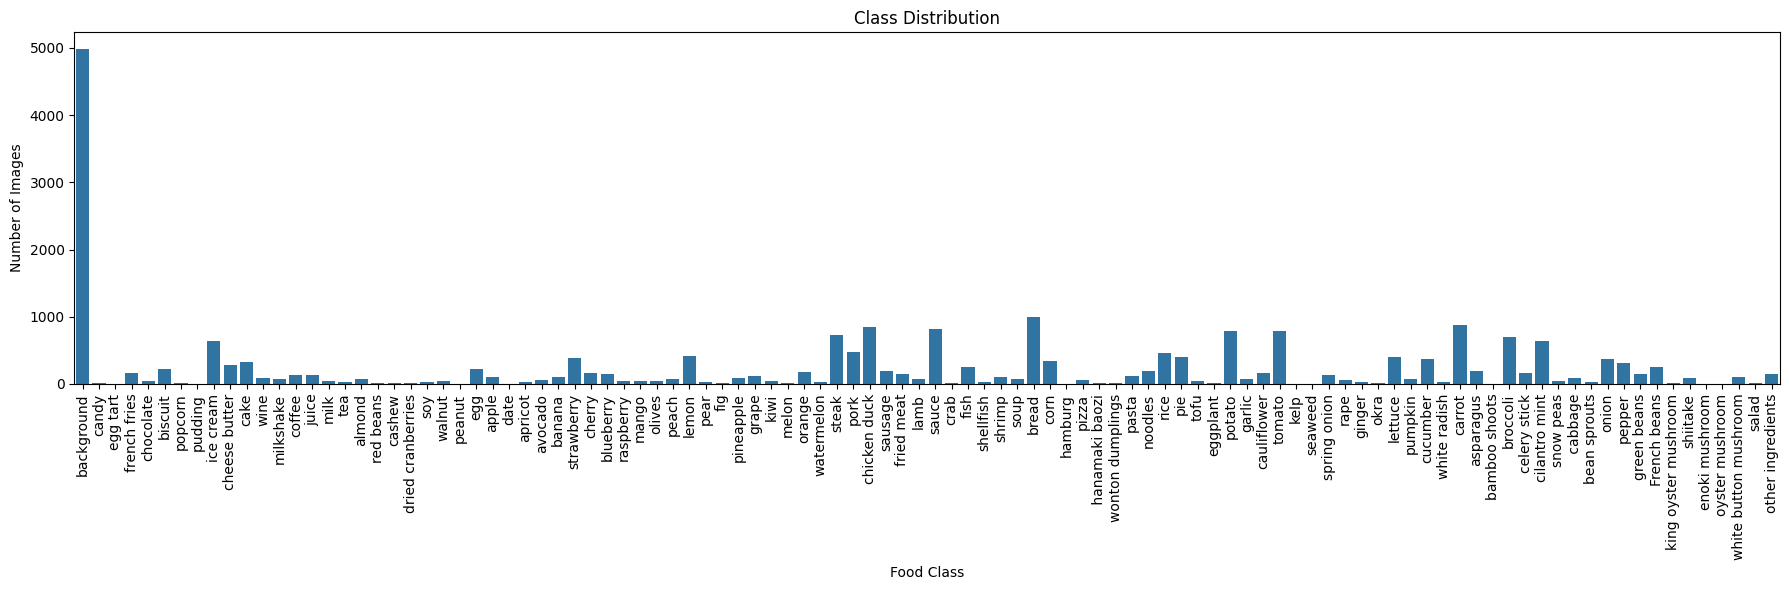

In [15]:
# Calculate class distribution in the training set

all_classes = []
for example in ds["train"]:
    all_classes.extend(example["classes_on_image"])

class_counts = Counter(all_classes)
class_names_ordered = [label_list[class_id] for class_id in range(len(label_list))]
counts_ordered = [class_counts.get(class_id, 0) for class_id in range(len(label_list))]

plt.figure(figsize=(18, 6))
sns.barplot(x=class_names_ordered, y=counts_ordered)
plt.xticks(rotation=90)
plt.xlabel("Food Class")
plt.ylabel("Number of Images")
plt.title("Class Distribution")
plt.tight_layout()
plt.show()

##### 1.3.2 Top 10 Most Frequent Ingredients
The bar plot below shows the top 10 most frequent ingredient classes in the training set (excluding background).

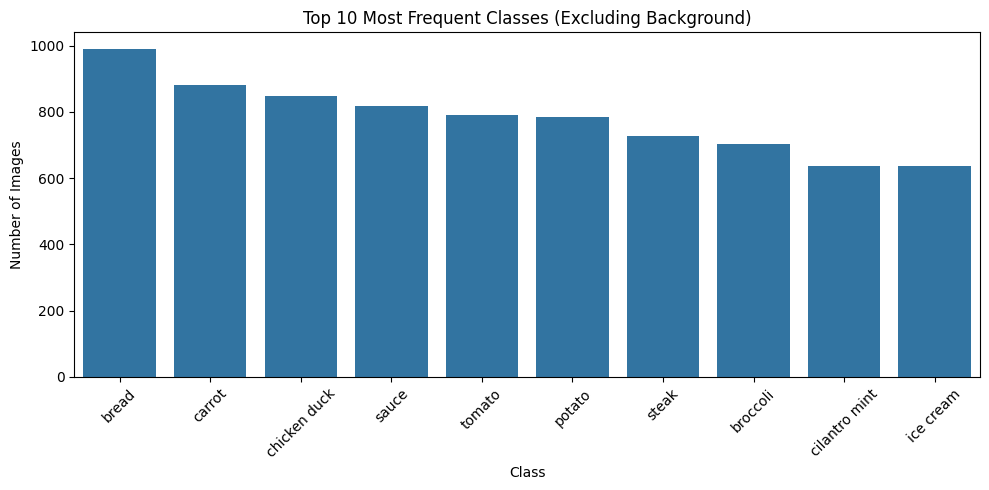

In [16]:
top10 = [item for item in class_counts.most_common() if item[0] != 0][:10]
top10_ids, top10_counts = zip(*top10)
top10_labels = [label_list[c] for c in top10_ids]

plt.figure(figsize=(10, 5))
sns.barplot(x=top10_labels, y=top10_counts)
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.title("Top 10 Most Frequent Classes (Excluding Background)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

##### 1.3.3 The Most Frequent Class
The most frequent class in the training set is **bread** (ID: 58), appearing in 991 images. We will use this class to create a smaller dataset for efficient training purposes.

In [17]:
# Calculate class counts
class_counts = Counter(all_classes)

# Get the most common class (excluding background, which is class 0)
top_class_id, top_class_count = next((cls_id, count) for cls_id, count in class_counts.most_common() if cls_id != 0)
top_class_name = label_list[top_class_id]
print(f"Most common class (excluding background): {top_class_name} (ID: {top_class_id}) - Count: {top_class_count}")

Most common class (excluding background): bread (ID: 58) - Count: 991


### 2. Preprocessing

#### 2.1 Filter Dataset
This step filters the dataset to retain only images containing the most frequent class (**bread**, ID: 58). This allows focused analysis and model training on a subset with sufficient samples.

In [18]:
# Apply filtering to ds to keep only images containing the top class
def filter_top_class(example):
    return top_class_id in example["classes_on_image"]

ds = ds.filter(filter_top_class)

In [19]:
# Recalculate num_classes after filtering
filtered_classes = set()
for example in ds["train"]:
    if "classes_on_image" in example:
        filtered_classes.update(example["classes_on_image"])
num_classes = len(filtered_classes)
print(f"Updated num_classes: {num_classes}")

Updated num_classes: 92


#### 2.2 Label Processing
To enable multi-label classification, each image's ingredient labels are converted into a one-hot encoded vector. This vector indicates the presence or absence of each ingredient class in the image, making it suitable for training classification models.

In [20]:
def one_hot_encode(example):
    ingredient_vector = torch.zeros(num_classes, dtype=torch.float32)
    if "classes_on_image" in example:
        for cls in example["classes_on_image"]:
            if 0 <= cls < num_classes:
                ingredient_vector[cls] = 1.0
    example["ingredient_vector"] = ingredient_vector
    return example

ds = ds.map(one_hot_encode)


#### 2.3 Image and Mask Transforms
All images and segmentation masks are resized to a fixed size of 256x256. This ensures consistent input dimensions for both classification and segmentation models. Images are normalized to match ImageNet statistics, and masks are converted to tensors with nearest-neighbor interpolation to preserve label integrity.

In [21]:
# Define torchvision transforms for resizing and tensor conversion
transform = transforms.Compose([
    transforms.Resize((256, 256), interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

label_transform = transforms.Compose([
    transforms.Resize((256, 256), interpolation=transforms.InterpolationMode.NEAREST),
    transforms.PILToTensor()
])

def resize_and_to_tensor(example):
    example['image'] = transform(example['image'])
    example['label'] = label_transform(example['label']).long().squeeze(0)

    return example

# Apply resizing and tensor conversion to all splits
ds = ds.map(resize_and_to_tensor)
ds.set_format("torch", columns=["image", "label", "ingredient_vector"])


#### 2.4 Train/Validation Split

In [22]:
train, validation = ds["train"], ds["validation"]
train, validation

(Dataset({
     features: ['image', 'label', 'classes_on_image', 'id', 'ingredient_vector'],
     num_rows: 991
 }),
 Dataset({
     features: ['image', 'label', 'classes_on_image', 'id', 'ingredient_vector'],
     num_rows: 414
 }))

#### 2.5 DataLoader Setup

In [23]:
train_loader = DataLoader(
    train, batch_size=8, shuffle=True, num_workers=4
)
val_loader = DataLoader(
    validation, batch_size=8, shuffle=False, num_workers=4
)

train_loader,val_loader

(<torch.utils.data.dataloader.DataLoader at 0x34789bf50>,
 <torch.utils.data.dataloader.DataLoader at 0x3477f9af0>)

In [24]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")

Using device: mps


### 3. Classification Model

#### 3.1 Model Architecture
The classification model uses a `ResNet-50` backbone pretrained on `ImageNet`. All layers are frozen except the final fully connected (fc) layer, which is replaced with a new linear layer to output logits for each ingredient class (`num_classes`). 

This enables multi-label classification, where the model predicts the presence or absence of each ingredient in an image. 

The model outputs a vector of logits, one per class, which are passed through a sigmoid activation during evaluation to obtain probabilities for each ingredient.

In [22]:
from torchvision.models import resnet50, ResNet50_Weights

model = resnet50(weights=ResNet50_Weights.DEFAULT)

for param in model.parameters():
    param.requires_grad = False

# Replace the final fully connected layer to match the number of ingredient classes
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

#### 3.2 Loss Function, Optimizer, and Learning Rate Scheduler

For multi-label ingredient classification, the `BCEWithLogitsLoss` is used, which combines a sigmoid layer and the binary cross-entropy loss in a single class. 

The optimizer is `Adam`, which adapts the learning rate for each parameter. 

In [23]:
import torch.optim as optim

# Define loss and optimizer
criterion = nn.BCEWithLogitsLoss()  # For multi-label classification
optimizer = optim.Adam(model.fc.parameters(), lr=1e-3)

#### 3.3 Training Loop


In [25]:
from sklearn.metrics import precision_score, recall_score, f1_score, average_precision_score

num_epochs = 20  

train_losses = []
val_losses = []
precisions = []
recalls = []
f1_scores = []
subset_accs = []
print("Starting training the classification model")
for epoch in range(num_epochs):
    # -----------------------------
    # TRAINING
    # -----------------------------
    model.train()
    running_loss = 0.0
    loop = tqdm(train_loader, desc=f"Epoch [{epoch + 1}/{num_epochs}] - Training", leave=False)
    for batch in loop:
        images = batch["image"].to(device)
        labels = batch["ingredient_vector"].to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        loop.set_postfix(loss=loss.item())

    train_loss = running_loss / len(train)

    # -----------------------------
    # VALIDATION
    # -----------------------------
    model.eval()
    val_loss = 0.0
    
    all_targets = []
    all_outputs = []
    
    with torch.no_grad():
        for batch in tqdm(val_loader, desc=f"Epoch [{epoch + 1}/{num_epochs}] - Validation", leave=False):
            images = batch["image"].to(device)
            labels = batch["ingredient_vector"].to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            
            # Collect for metrics
            all_targets.append(labels.cpu().numpy())
            all_outputs.append(outputs.cpu().numpy())

    val_loss /= len(validation)
    
    all_targets = np.concatenate(all_targets, axis=0)
    all_outputs = np.concatenate(all_outputs, axis=0)

    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    preds_np = (all_outputs > 0.5).astype(np.float32)

    precisions.append(precision_score(all_targets, preds_np, average='macro', zero_division=0))
    recalls.append(recall_score(all_targets, preds_np, average='macro', zero_division=0))
    f1_scores.append(f1_score(all_targets, preds_np, average='macro', zero_division=0))
    subset_accs.append(np.mean(np.all(preds_np == all_targets, axis=1)))
    
    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {train_loss:.4f} | "
          f"Val Loss: {val_loss:.4f}")

# Save final model
torch.save(model.state_dict(), "models/classification_small_20.pth")


Starting training the classification model


Epoch [1/20] Train Loss: 0.0938 | Val Loss: 0.0985


Epoch [2/20] Train Loss: 0.0873 | Val Loss: 0.0966


Epoch [3/20] Train Loss: 0.0820 | Val Loss: 0.0937


Epoch [4/20] Train Loss: 0.0747 | Val Loss: 0.0919


Epoch [5/20] Train Loss: 0.0702 | Val Loss: 0.0909


Epoch [6/20] Train Loss: 0.0662 | Val Loss: 0.0908


Epoch [7/20] Train Loss: 0.0618 | Val Loss: 0.0895


Epoch [8/20] Train Loss: 0.0587 | Val Loss: 0.0886


Epoch [9/20] Train Loss: 0.0560 | Val Loss: 0.0879


Epoch [10/20] Train Loss: 0.0526 | Val Loss: 0.0877


Epoch [11/20] Train Loss: 0.0506 | Val Loss: 0.0876


Epoch [12/20] Train Loss: 0.0476 | Val Loss: 0.0872


Epoch [13/20] Train Loss: 0.0457 | Val Loss: 0.0875


Epoch [14/20] Train Loss: 0.0436 | Val Loss: 0.0869


Epoch [15/20] Train Loss: 0.0415 | Val Loss: 0.0865


Epoch [16/20] Train Loss: 0.0401 | Val Loss: 0.0877


Epoch [17/20] Train Loss: 0.0390 | Val Loss: 0.0867


Epoch [18/20] Train Loss: 0.0377 | Val Loss: 0.0859


Epoch [19/20] Train Loss: 0.0359 | Val Loss: 0.0885


Epoch [20/20] Train Loss: 0.0350 | Val Loss: 0.0869


#### 3.3 Evaluation Metrics
The classification model is evaluated using several metrics:

- **Precision**: Measures the proportion of predicted ingredient labels that are actually present in the image. Low precision indicates many false positives.

- **Recall**: Measures the proportion of true ingredient labels that are correctly predicted by the model. Low recall indicates many missed ingredients.

- **F1 Score**: The harmonic mean of precision and recall, providing a balanced measure of accuracy for multi-label classification.

- **Subset Accuracy**: The percentage of images for which all ingredient labels are predicted exactly. This is a strict metric and typically low for multi-label tasks.


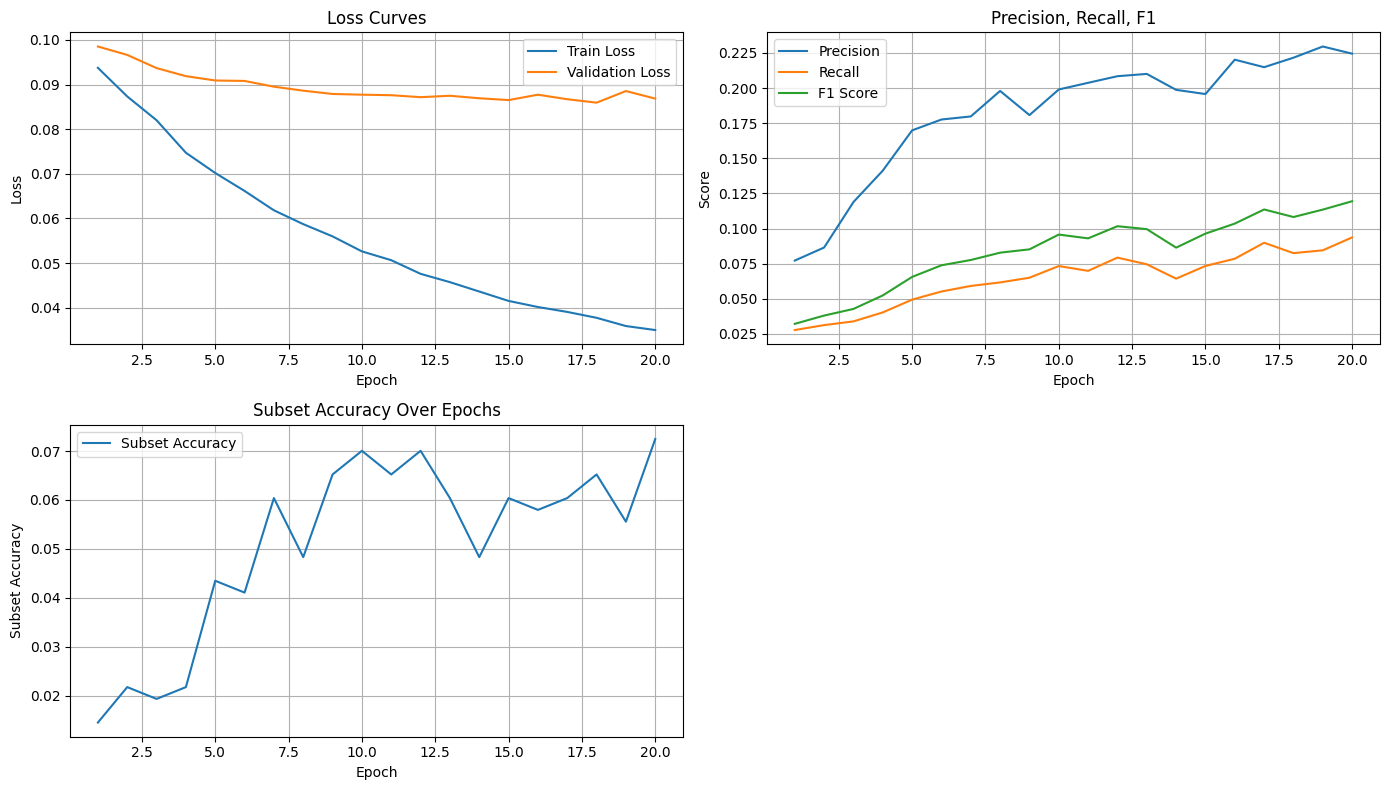

In [26]:
import numpy as np

import matplotlib.pyplot as plt

epochs = np.arange(1, len(train_losses) + 1)

plt.figure(figsize=(14, 8))

plt.subplot(2, 2, 1)
plt.plot(epochs, train_losses, label="Train Loss")
plt.plot(epochs, val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curves")
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 2)
plt.plot(epochs, precisions, label="Precision")
plt.plot(epochs, recalls, label="Recall")
plt.plot(epochs, f1_scores, label="F1 Score")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.title("Precision, Recall, F1")
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 3)
plt.plot(epochs, subset_accs, label="Subset Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Subset Accuracy")
plt.title("Subset Accuracy Over Epochs")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


**Results Summary:**

The classification model demonstrates limited ability to accurately identify all ingredient classes in multi-label food images. 

Precision is low, indicating a tendency to predict ingredients that are not present (false positives). 
Recall is also low, showing that many true ingredients are missed by the model. 
The F1 score, which balances precision and recall, remains modest, reflecting overall challenges in multi-label classification. 
Subset accuracy is very low, meaning the model rarely predicts all ingredients in an image exactly. 


#### 3.4 Prediction Examples

In [ ]:
num_display = 6
fig, axes = plt.subplots(2, 3, figsize=(12, 10))
axes = axes.flatten()

shown = 0

model.eval()
with torch.no_grad():
    for batch in val_loader:
        images = batch["image"].to(device)
        targets = batch["ingredient_vector"]

        outputs = model(images)
        if isinstance(outputs, tuple):
            outputs = outputs[0]
        probs = torch.sigmoid(outputs).cpu().numpy()
        preds = (probs > 0.5).astype(int)

        for j in range(len(images)):
            if shown >= num_display:
                break

            ax = axes[shown]
            img_np = images[j].cpu().permute(1, 2, 0).numpy()
            img_np = (img_np * np.array([0.229, 0.224, 0.225])) + np.array([0.485, 0.456, 0.406])
            img_np = img_np.clip(0, 1)
            ax.imshow(img_np)

            true_idxs = np.where(targets[j].cpu().numpy() == 1)[0]
            pred_idxs = np.where(preds[j] == 1)[0]
            true_labels = [label_list[k] for k in true_idxs]
            pred_labels = [label_list[k] for k in pred_idxs]

            ax.set_title(f"True: {true_labels}\nPred: {pred_labels}", fontsize=8)
            ax.axis("off")

            shown += 1

        if shown >= num_display:
            break

plt.tight_layout()
plt.show()


### 4. Segmentation Model

#### 4.1 Model Architecture
The segmentation model uses `DeepLabV3` with a `ResNet-50` backbone, a popular architecture for semantic segmentation. The backbone extracts hierarchical image features, while the `DeepLabV3` head applies *Atrous Spatial Pyramid Pooling* (ASPP) to capture multi-scale context. 

The final classifier layer is replaced to output `num_classes` channels, matching the number of ingredient classes in the dataset. This enables pixel-wise classification for each ingredient class in the input image. The model is initialized with pretrained weights for improved performance.

In [25]:
model = get_model("deeplabv3_resnet50", weights="DEFAULT")
model.classifier[-1] = nn.Conv2d(model.classifier[-1].in_channels, num_classes, kernel_size=1)

#### 4.2 Loss Functions and Evaluation Metrics

This section defines the loss functions and evaluation metrics used for training and validating the segmentation model. The primary loss is `CrossEntropyLoss`, suitable for multi-class pixel-wise segmentation. 

Evaluation metrics include **pixel accuracy**, **per-class Intersection over Union** (IoU), **mean IoU**, and **Dice score**, providing a comprehensive assessment of segmentation performance across all ingredient classes.

In [26]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [27]:
def pixel_accuracy(outputs, labels):
    outputs = outputs.cpu()
    labels = labels.cpu()
    preds = torch.argmax(outputs, dim=1)
    correct = (preds == labels).float()
    acc = correct.sum() / correct.numel()
    return acc.item()

def per_class_iou(outputs, labels, num_classes):
    outputs = outputs.cpu()
    labels = labels.cpu()
    preds = torch.argmax(outputs, dim=1)
    ious = []
    for cls in range(num_classes):
        pred_inds = (preds == cls)
        target_inds = (labels == cls)
        intersection = (pred_inds & target_inds).sum().item()
        union = (pred_inds | target_inds).sum().item()
        if union == 0:
            ious.append(float('nan'))
        else:
            ious.append(intersection / union)
    return ious

def mean_iou(outputs, labels, num_classes):
    outputs = outputs.cpu()
    labels = labels.cpu()
    ious = per_class_iou(outputs, labels, num_classes)
    valid_ious = [iou for iou in ious if not np.isnan(iou)]
    return np.mean(valid_ious)

def dice_score(outputs, labels, num_classes):
    outputs = outputs.cpu()
    labels = labels.cpu()
    preds = torch.argmax(outputs, dim=1)
    dice_scores = []
    for cls in range(num_classes):
        pred_inds = (preds == cls)
        target_inds = (labels == cls)
        intersection = (pred_inds & target_inds).sum().item()
        pred_sum = pred_inds.sum().item()
        target_sum = target_inds.sum().item()
        if pred_sum + target_sum == 0:
            dice_scores.append(float('nan'))
        else:
            dice_scores.append(2 * intersection / (pred_sum + target_sum))
    return dice_scores

#### 4.3 Training Loop
The training loop for the segmentation model iterates over a fixed number of epochs, alternating between training and validation phases. In each training epoch, the model processes batches of images and segmentation masks, computes the cross-entropy loss, and updates the model weights using backpropagation. 

After each epoch, the model is evaluated on the validation set, where losses and segmentation metrics are computed and tracked. The training and validation losses, as well as the metrics, are stored for later visualization. 

The best model is saved at the end of training. This process enables monitoring of both model convergence and segmentation performance over time.

In [28]:
num_epochs = 20

model = model.to(device)

# losses
train_losses = []
val_losses = []

# metrics
pixel_accs = []
ious_list = []
dice_list = []

for epoch in range(num_epochs):
    # -----------------------------
    # TRAINING
    # -----------------------------
    model.train()
    running_loss = 0.0
    loop = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}] - Training", leave=False)

    for batch in loop:
        images = batch["image"].to(device)
        labels = batch["label"].to(device).squeeze(1)

        optimizer.zero_grad()
        outputs = model(images)["out"]
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        loop.set_postfix(loss=loss.item())

    epoch_train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_train_loss)

    # -----------------------------
    # VALIDATION
    # -----------------------------
    model.eval()
    val_loss = 0.0
    epoch_pixel_acc = []
    epoch_ious = []
    epoch_dices = []

    with torch.no_grad():
        for batch in tqdm(val_loader, desc=f"Epoch [{epoch+1}/{num_epochs}] - Validation", leave=False):
            images = batch["image"].to(device)
            labels = batch["label"].to(device).squeeze(1)

            outputs = model(images)["out"]
            loss = loss_fn(outputs, labels)
            val_loss += loss.item() * images.size(0)

            # metrics per batch
            epoch_pixel_acc.append(pixel_accuracy(outputs, labels))
            epoch_ious.append(per_class_iou(outputs, labels, num_classes))
            epoch_dices.append(dice_score(outputs, labels, num_classes))

    # compute per-epoch means
    epoch_val_loss = val_loss / len(val_loader.dataset)
    val_losses.append(epoch_val_loss)

    pixel_accs.append(np.mean(epoch_pixel_acc))
    ious_list.append(np.nanmean(np.array(epoch_ious), axis=0))
    dice_list.append(np.nanmean(np.array(epoch_dices), axis=0))

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {epoch_train_loss:.4f} | "
          f"Val Loss: {epoch_val_loss:.4f}")

# save model
torch.save(model.state_dict(), "models/segmentation_small_20.pth")


/var/folders/qv/8ghds0hx12s2tw7v8qcq17580000gn/T/ipykernel_95654/3969596866.py:66: RuntimeWarning: Mean of empty slice
  ious_list.append(np.nanmean(np.array(epoch_ious), axis=0))
/var/folders/qv/8ghds0hx12s2tw7v8qcq17580000gn/T/ipykernel_95654/3969596866.py:67: RuntimeWarning: Mean of empty slice
  dice_list.append(np.nanmean(np.array(epoch_dices), axis=0))


Epoch [1/20] Train Loss: 2.7827 | Val Loss: 2.0390


Epoch [2/20] Train Loss: 1.7321 | Val Loss: 1.5055


Epoch [3/20] Train Loss: 1.3527 | Val Loss: 1.2557


Epoch [4/20] Train Loss: 1.1453 | Val Loss: 1.1215


Epoch [5/20] Train Loss: 0.9928 | Val Loss: 1.0495


Epoch [6/20] Train Loss: 0.8888 | Val Loss: 1.0119


Epoch [7/20] Train Loss: 0.7952 | Val Loss: 0.9693


Epoch [8/20] Train Loss: 0.6953 | Val Loss: 0.9658


Epoch [9/20] Train Loss: 0.6255 | Val Loss: 0.9585


Epoch [10/20] Train Loss: 0.5575 | Val Loss: 0.9375


Epoch [11/20] Train Loss: 0.4981 | Val Loss: 0.9325


Epoch [12/20] Train Loss: 0.4457 | Val Loss: 0.9125


Epoch [13/20] Train Loss: 0.3995 | Val Loss: 0.9207


Epoch [14/20] Train Loss: 0.3535 | Val Loss: 0.9155


Epoch [15/20] Train Loss: 0.3121 | Val Loss: 0.9015


Epoch [16/20] Train Loss: 0.2660 | Val Loss: 0.8906


Epoch [17/20] Train Loss: 0.2390 | Val Loss: 0.8977


Epoch [18/20] Train Loss: 0.2157 | Val Loss: 0.9072


Epoch [19/20] Train Loss: 0.1974 | Val Loss: 0.8859


Epoch [20/20] Train Loss: 0.1824 | Val Loss: 0.9148


#### 4.4 Evaluation Metrics
The segmentation model is evaluated using several metrics:

- **Pixel Accuracy**: Measures the proportion of correctly classified pixels over all pixels. High pixel accuracy indicates that most pixels are assigned the correct class, but it can be biased by dominant classes.

- **Mean IoU (Intersection over Union)**: Computes the average IoU across all classes, where IoU for each class is the ratio of the intersection to the union of predicted and ground truth pixels. This metric is robust to class imbalance and reflects how well the model segments each class.

- **Mean Dice Score**: The Dice coefficient is another overlap metric, similar to IoU, but gives more weight to correctly predicted pixels. The mean Dice score averages this value across all classes, providing a balanced view of segmentation quality.


In [29]:
mean_pixel_acc = np.mean(pixel_accs)
mean_ious = np.nanmean(np.array(ious_list), axis=0)
mean_iou_score = np.nanmean(mean_ious)
mean_dice = np.nanmean(np.array(dice_list), axis=0)
mean_dice_score = np.nanmean(mean_dice)

print(f"Pixel Accuracy: {mean_pixel_acc:.4f}")
print(f"Mean IoU: {mean_iou_score:.4f}")
print(f"Mean Dice Score: {mean_dice_score:.4f}")

Pixel Accuracy: 0.7544
Mean IoU: 0.0824
Mean Dice Score: 0.1015


/var/folders/qv/8ghds0hx12s2tw7v8qcq17580000gn/T/ipykernel_95654/2059818741.py:2: RuntimeWarning: Mean of empty slice
  mean_ious = np.nanmean(np.array(ious_list), axis=0)
/var/folders/qv/8ghds0hx12s2tw7v8qcq17580000gn/T/ipykernel_95654/2059818741.py:4: RuntimeWarning: Mean of empty slice
  mean_dice = np.nanmean(np.array(dice_list), axis=0)


**Results Summary:** 

- **Pixel Accuracy:** The model correctly classifies a big percentage of all pixels, indicating good performance on dominant classes (background).
- **Mean IoU:** The low mean Intersection over Union shows poor overlap between predicted and true masks, especially for minority classes.
- **Mean Dice Score:** The low mean Dice score further confirms that the model struggles to segment less frequent ingredient classes.

Overall, while the model achieves high pixel accuracy by favoring common classes like **background**, its ability to segment all ingredient classes (especially rare ones) remains limited.


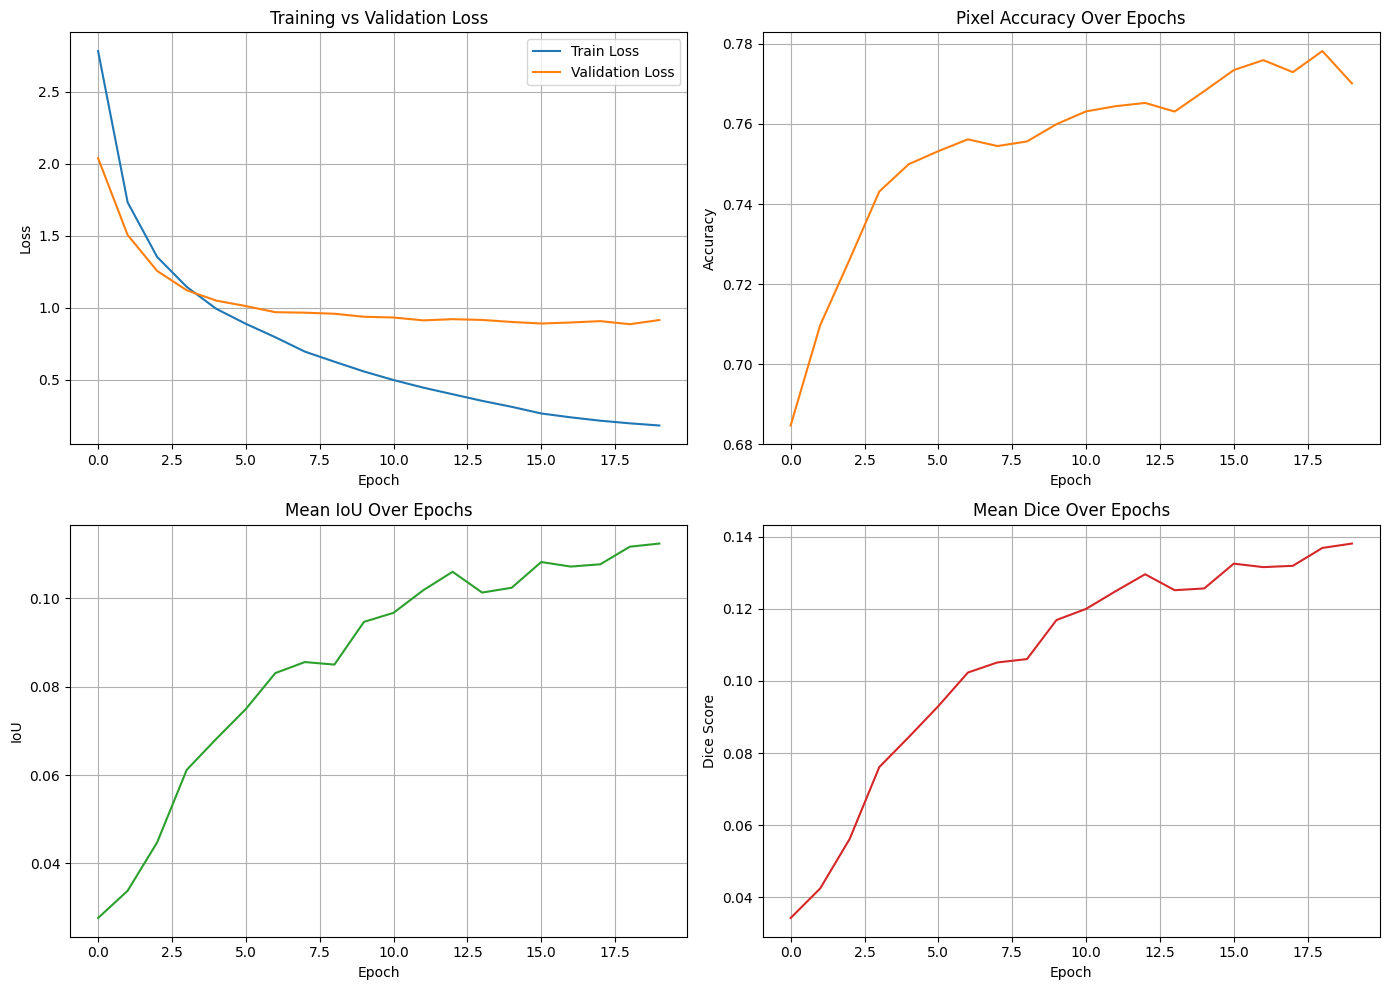

In [30]:
import matplotlib.pyplot as plt
import numpy as np
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# ---- Loss Curves ----
axs[0, 0].plot(train_losses, label="Train Loss")
axs[0, 0].plot(val_losses, label="Validation Loss")
axs[0, 0].set_xlabel("Epoch")
axs[0, 0].set_ylabel("Loss")
axs[0, 0].set_title("Training vs Validation Loss")
axs[0, 0].legend()
axs[0, 0].grid(True)

# ---- Pixel Accuracy ----
axs[0, 1].plot(pixel_accs, label="Pixel Accuracy", color='tab:orange')
axs[0, 1].set_xlabel("Epoch")
axs[0, 1].set_ylabel("Accuracy")
axs[0, 1].set_title("Pixel Accuracy Over Epochs")
axs[0, 1].grid(True)

# ---- Mean IoU ----
mean_ious = [np.nanmean(iou) for iou in ious_list]
axs[1, 0].plot(mean_ious, label="Mean IoU", color='tab:green')
axs[1, 0].set_xlabel("Epoch")
axs[1, 0].set_ylabel("IoU")
axs[1, 0].set_title("Mean IoU Over Epochs")
axs[1, 0].grid(True)

# ---- Mean Dice ----
mean_dices = [np.nanmean(dice) for dice in dice_list]
axs[1, 1].plot(mean_dices, label="Mean Dice", color='tab:red')
axs[1, 1].set_xlabel("Epoch")
axs[1, 1].set_ylabel("Dice Score")
axs[1, 1].set_title("Mean Dice Over Epochs")
axs[1, 1].grid(True)

plt.tight_layout()
plt.show()


/var/folders/qv/8ghds0hx12s2tw7v8qcq17580000gn/T/ipykernel_95654/1994754125.py:2: RuntimeWarning: Mean of empty slice
  mean_ious_per_class = np.nanmean(np.array(ious_list), axis=0)


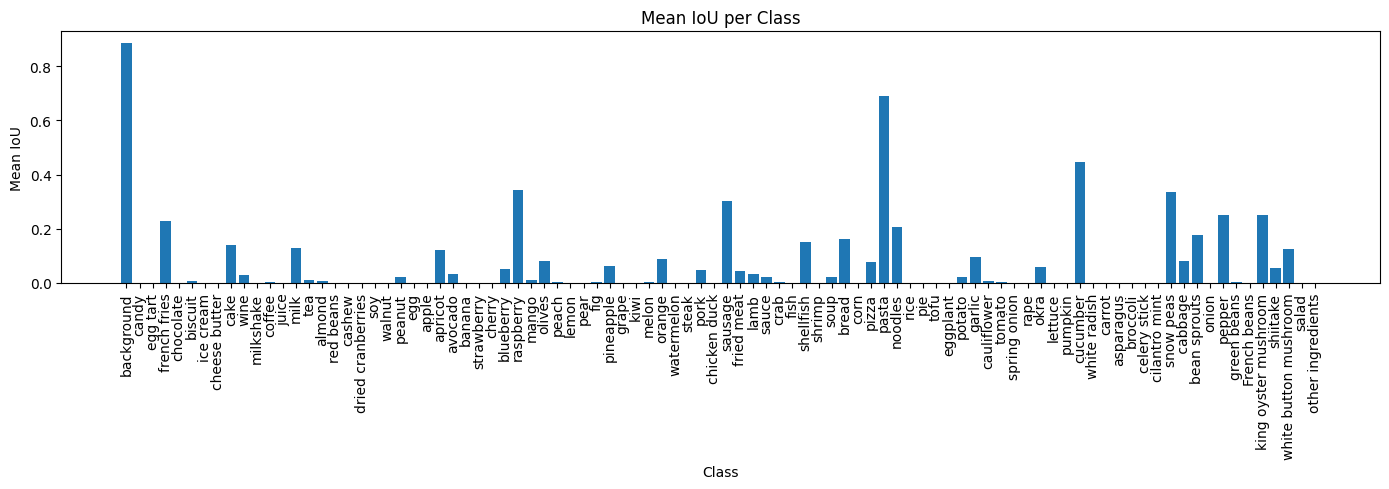

In [31]:
# Compute mean IoU per class across all epochs
mean_ious_per_class = np.nanmean(np.array(ious_list), axis=0)
plt.figure(figsize=(14, 5))
plt.bar(range(num_classes), mean_ious_per_class)
filtered_label_list = [label_list[c] for c in sorted(filtered_classes)]
plt.xticks(range(len(filtered_label_list)), filtered_label_list, rotation=90)
plt.xlabel("Class")
plt.ylabel("Mean IoU")
plt.title("Mean IoU per Class")
plt.tight_layout()
plt.show()


#### 4.5 Prediction Examples

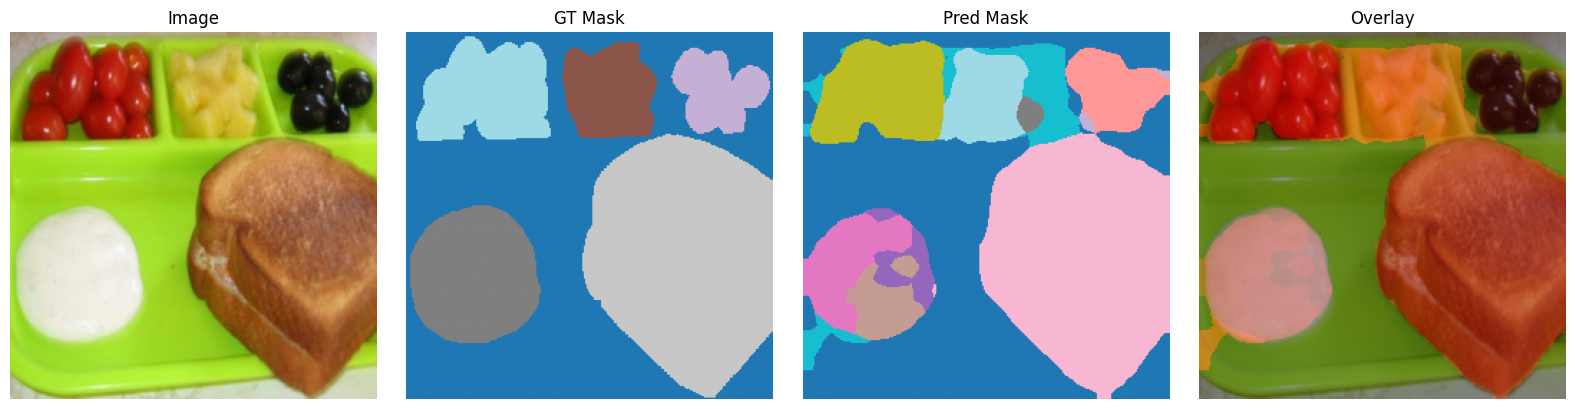

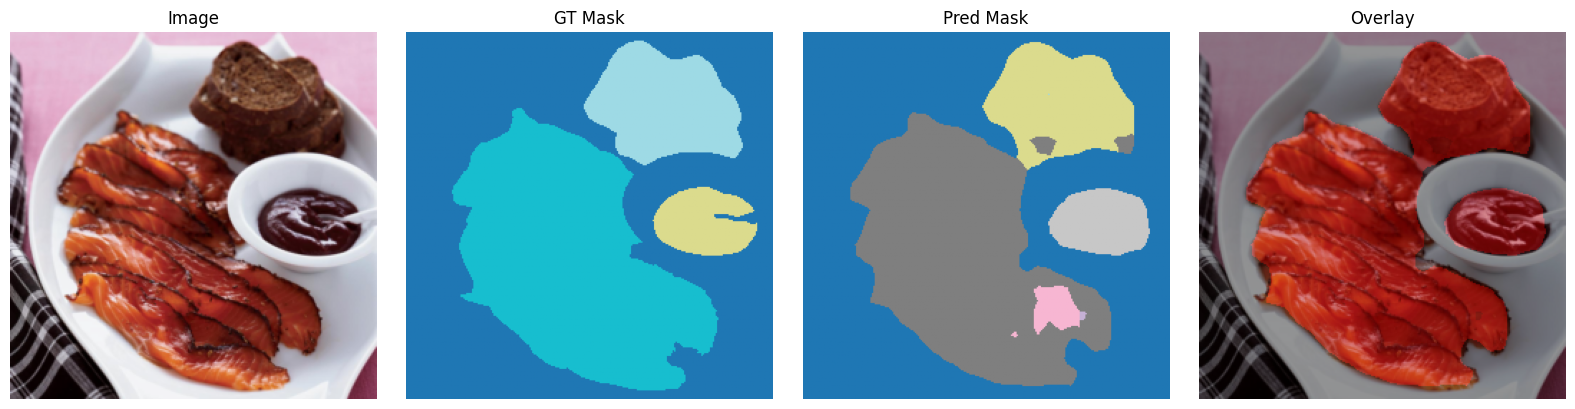

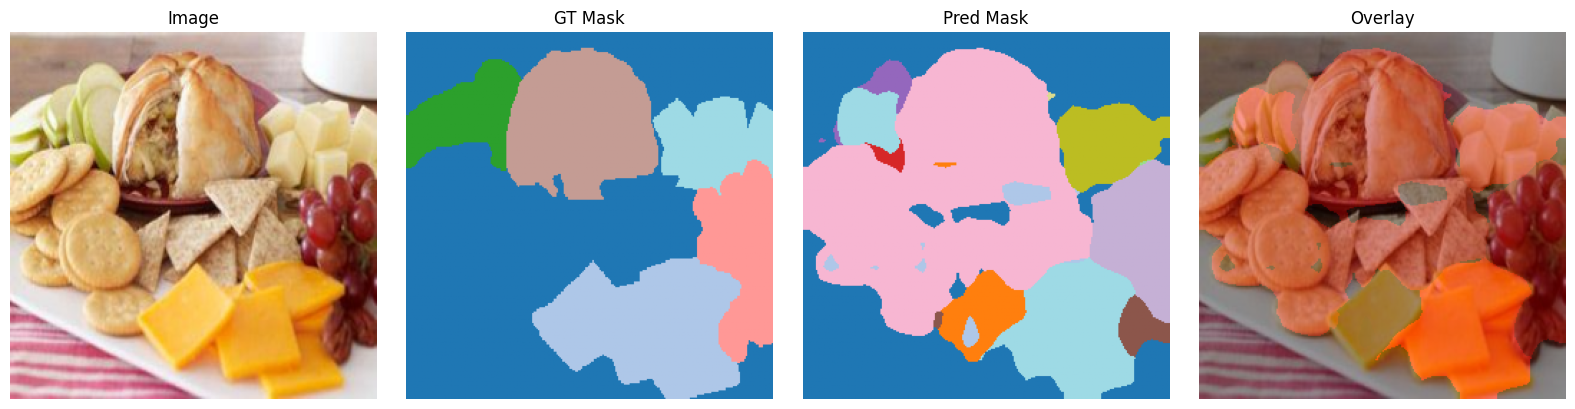

In [32]:
# Get a batch from validation loader
batch = next(iter(val_loader))
images = batch["image"].to(device)
labels = batch["label"].cpu().numpy()  # (N, H, W)

# Get model predictions
model.eval()
with torch.no_grad():
    outputs = model(images)["out"]
    preds = torch.argmax(outputs, dim=1).cpu().numpy()  # (N, H, W)

# Show for the first 3 images in the batch
num_show = 3
for i in range(num_show):
    img = images[i].cpu().permute(1, 2, 0).numpy()
    img = (img * [0.229, 0.224, 0.225]) + [0.485, 0.456, 0.406]  # unnormalize
    img = img.clip(0, 1)

    gt_mask = labels[i]
    pred_mask = preds[i]

    # Overlay predicted mask on image
    overlay = img.copy()
    color_mask = np.zeros_like(img)
    color_mask[..., 0] = pred_mask / pred_mask.max()  # Red channel
    overlay = 0.6 * img + 0.4 * color_mask

    fig, axs = plt.subplots(1, 4, figsize=(16, 4))
    axs[0].imshow(img)
    axs[0].set_title("Image")
    if gt_mask.ndim == 3 and gt_mask.shape[0] == 1:
        gt_mask = gt_mask.squeeze(0)
    axs[1].imshow(gt_mask, cmap='tab20')
    axs[1].set_title("GT Mask")
    axs[2].imshow(pred_mask, cmap='tab20')
    axs[2].set_title("Pred Mask")
    axs[3].imshow(overlay)
    axs[3].set_title("Overlay")
    for ax in axs:
        ax.axis('off')
    plt.tight_layout()
    plt.show()

### 5. Multi-Task Model

#### 5.1 Model Architecture
The multi-task model is based on DeepLabV3 with a ResNet-50 backbone and is designed to perform both ingredient classification and segmentation simultaneously. The backbone extracts shared image features, which are then processed by two separate heads:

- **Classification Head:** Applies global average pooling to the backbone features and uses a linear layer to predict the presence of each ingredient class in the image (multi-label classification).
- **Segmentation Head:** Uses the DeepLabV3 ASPP module and classifier to produce pixel-wise segmentation masks for all ingredient classes.

This architecture enables joint learning, allowing the model to leverage shared representations for both tasks and potentially improve performance compared to training each task independently. Pretrained weights are loaded for the backbone and segmentation head to accelerate convergence.

In [16]:
from torchvision.models.segmentation import deeplabv3_resnet50
import torch.nn.functional as F

class MultiTaskDeepLab(nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        # Load DeepLabV3-ResNet50 with correct classifier shape
        deeplab = deeplabv3_resnet50(weights=None, num_classes=num_classes)

        # Shared backbone
        self.backbone = deeplab.backbone      # dict: {"out": features}

        # Shared ASPP segmentation head
        self.segmentation_head = deeplab.classifier

        # Classification head (global pooled backbone features)
        self.classifier = nn.Linear(2048, num_classes)

    def forward(self, x):
        # 1. Backbone
        features = self.backbone(x)["out"]     # [B, 2048, H/32, W/32]

        # 2. Classification head
        pooled = F.adaptive_avg_pool2d(features, (1, 1)).flatten(1)
        cls_logits = self.classifier(pooled)

        # 3. Segmentation head
        seg_logits = self.segmentation_head(features)
        if isinstance(seg_logits, dict) and "out" in seg_logits:
            seg_logits = seg_logits["out"]
        seg_logits = F.interpolate(seg_logits, size=x.shape[2:], mode="bilinear", align_corners=False)

        return cls_logits, seg_logits

# Instantiate model
model = MultiTaskDeepLab(num_classes).to(device)

# Load DeepLab pretrained weights
state = torch.load("models/segmentation_small_20.pth", map_location=device)
model.load_state_dict(state, strict=False)

_IncompatibleKeys(missing_keys=['segmentation_head.0.convs.0.0.weight', 'segmentation_head.0.convs.0.1.weight', 'segmentation_head.0.convs.0.1.bias', 'segmentation_head.0.convs.0.1.running_mean', 'segmentation_head.0.convs.0.1.running_var', 'segmentation_head.0.convs.1.0.weight', 'segmentation_head.0.convs.1.1.weight', 'segmentation_head.0.convs.1.1.bias', 'segmentation_head.0.convs.1.1.running_mean', 'segmentation_head.0.convs.1.1.running_var', 'segmentation_head.0.convs.2.0.weight', 'segmentation_head.0.convs.2.1.weight', 'segmentation_head.0.convs.2.1.bias', 'segmentation_head.0.convs.2.1.running_mean', 'segmentation_head.0.convs.2.1.running_var', 'segmentation_head.0.convs.3.0.weight', 'segmentation_head.0.convs.3.1.weight', 'segmentation_head.0.convs.3.1.bias', 'segmentation_head.0.convs.3.1.running_mean', 'segmentation_head.0.convs.3.1.running_var', 'segmentation_head.0.convs.4.1.weight', 'segmentation_head.0.convs.4.2.weight', 'segmentation_head.0.convs.4.2.bias', 'segmentation_

#### 5.2 Loss Functions
The multi-task model is trained using a joint loss that combines both classification and segmentation objectives.

The total loss is the sum of the classification and segmentation losses, encouraging the model to learn features useful for both tasks simultaneously. During training, gradients from both losses are backpropagated to update the shared backbone and task-specific heads.

In [17]:
# Training setup
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
cls_criterion = nn.BCEWithLogitsLoss()
seg_criterion = nn.CrossEntropyLoss()

#### 5.2 Training Loop

In [18]:
from sklearn.metrics import precision_score, recall_score, f1_score, average_precision_score

best_val_loss = float('inf')

# Model Losses
train_losses = []
val_losses = []

# Classification Metrics
precisions = []
recalls = []
f1_scores = []
subset_accs = []

# Segmentation Metrics
pixel_accs = []
ious_list = []
dice_list = []

num_epochs = 20

for epoch in range(num_epochs):
    # -----------------------------
    # TRAINING
    # -----------------------------
    model.train()
    running_loss = 0.0

    for batch in tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}] - Training", leave=False):
        images = batch["image"].to(device)
        cls_targets = batch["ingredient_vector"].to(device)
        seg_targets = batch["label"].to(device).squeeze(1)

        optimizer.zero_grad()
        cls_logits, seg_logits = model(images)

        cls_loss = cls_criterion(cls_logits, cls_targets)
        seg_loss = seg_criterion(seg_logits, seg_targets)
        loss = cls_loss + seg_loss

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    
    # -----------------------------
    # VALIDATION
    # -----------------------------
    model.eval()
    val_running_loss = 0.0
    
    all_cls_targets, all_cls_preds = [], []

    epoch_pixel_acc = []
    epoch_ious = []
    epoch_dices = []
    

    with torch.no_grad():
        for batch in tqdm(val_loader, desc=f"Epoch [{epoch+1}/{num_epochs}] - Validation", leave=False):
            images = batch["image"].to(device)
            cls_targets = batch["ingredient_vector"].cpu().numpy()
            seg_targets = batch["label"].squeeze(1)
            
            cls_logits, seg_logits = model(images)
            
            # Classification
            cls_probs = torch.sigmoid(cls_logits).cpu().numpy()
            cls_preds = (cls_probs > 0.5).astype(int)
            all_cls_targets.append(cls_targets)
            all_cls_preds.append(cls_preds)
            
            val_running_loss += loss.item() * images.size(0)

            
            # Segmentation metrics per batch
            epoch_pixel_acc.append(pixel_accuracy(seg_logits, seg_targets))
            epoch_ious.append(per_class_iou(seg_logits, seg_targets, num_classes))
            epoch_dices.append(dice_score(seg_logits, seg_targets, num_classes))

    val_epoch_loss = val_running_loss / len(val_loader.dataset)
    
    train_losses.append(val_running_loss)
    val_losses.append(val_epoch_loss)
    
    # Concatenate results
    all_cls_targets = np.concatenate(all_cls_targets, axis=0)
    all_cls_preds = np.concatenate(all_cls_preds, axis=0)
    
    all_cls_preds = (all_cls_preds > 0.5).astype(np.float32)

    # Classification
    precisions.append(precision_score(all_cls_targets, all_cls_preds, average='macro', zero_division=0))
    recalls.append(recall_score(all_cls_targets, all_cls_preds, average='macro', zero_division=0))
    f1_scores.append(f1_score(all_cls_targets, all_cls_preds, average='macro', zero_division=0))
    subset_accs.append(np.mean(np.all(all_cls_targets == all_cls_preds, axis=1)))
    
    # Segmentation
    pixel_accs.append(np.mean(epoch_pixel_acc))
    ious_list.append(np.nanmean(np.array(epoch_ious), axis=0))
    dice_list.append(np.nanmean(np.array(epoch_dices), axis=0))
    
    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Joint Loss: {epoch_loss:.4f} | "
          f"Val Joint Loss: {val_epoch_loss:.4f}")

    # Save best model
    if val_epoch_loss < best_val_loss:
        best_val_loss = val_epoch_loss
        torch.save(model.state_dict(), "models/multitask_small_20.pth")


/var/folders/qv/8ghds0hx12s2tw7v8qcq17580000gn/T/ipykernel_79204/1738468609.py:102: RuntimeWarning: Mean of empty slice
  ious_list.append(np.nanmean(np.array(epoch_ious), axis=0))
/var/folders/qv/8ghds0hx12s2tw7v8qcq17580000gn/T/ipykernel_79204/1738468609.py:103: RuntimeWarning: Mean of empty slice
  dice_list.append(np.nanmean(np.array(epoch_dices), axis=0))


Epoch [1/20] Train Joint Loss: 1.8610 | Val Joint Loss: 1.0551


/var/folders/qv/8ghds0hx12s2tw7v8qcq17580000gn/T/ipykernel_79204/1738468609.py:102: RuntimeWarning: Mean of empty slice
  ious_list.append(np.nanmean(np.array(epoch_ious), axis=0))
/var/folders/qv/8ghds0hx12s2tw7v8qcq17580000gn/T/ipykernel_79204/1738468609.py:103: RuntimeWarning: Mean of empty slice
  dice_list.append(np.nanmean(np.array(epoch_dices), axis=0))


Epoch [2/20] Train Joint Loss: 0.8250 | Val Joint Loss: 0.4262


/var/folders/qv/8ghds0hx12s2tw7v8qcq17580000gn/T/ipykernel_79204/1738468609.py:102: RuntimeWarning: Mean of empty slice
  ious_list.append(np.nanmean(np.array(epoch_ious), axis=0))
/var/folders/qv/8ghds0hx12s2tw7v8qcq17580000gn/T/ipykernel_79204/1738468609.py:103: RuntimeWarning: Mean of empty slice
  dice_list.append(np.nanmean(np.array(epoch_dices), axis=0))


Epoch [3/20] Train Joint Loss: 0.5872 | Val Joint Loss: 0.3481


/var/folders/qv/8ghds0hx12s2tw7v8qcq17580000gn/T/ipykernel_79204/1738468609.py:102: RuntimeWarning: Mean of empty slice
  ious_list.append(np.nanmean(np.array(epoch_ious), axis=0))
/var/folders/qv/8ghds0hx12s2tw7v8qcq17580000gn/T/ipykernel_79204/1738468609.py:103: RuntimeWarning: Mean of empty slice
  dice_list.append(np.nanmean(np.array(epoch_dices), axis=0))


Epoch [4/20] Train Joint Loss: 0.4584 | Val Joint Loss: 0.3033


/var/folders/qv/8ghds0hx12s2tw7v8qcq17580000gn/T/ipykernel_79204/1738468609.py:102: RuntimeWarning: Mean of empty slice
  ious_list.append(np.nanmean(np.array(epoch_ious), axis=0))
/var/folders/qv/8ghds0hx12s2tw7v8qcq17580000gn/T/ipykernel_79204/1738468609.py:103: RuntimeWarning: Mean of empty slice
  dice_list.append(np.nanmean(np.array(epoch_dices), axis=0))


Epoch [5/20] Train Joint Loss: 0.4009 | Val Joint Loss: 0.4758


/var/folders/qv/8ghds0hx12s2tw7v8qcq17580000gn/T/ipykernel_79204/1738468609.py:102: RuntimeWarning: Mean of empty slice
  ious_list.append(np.nanmean(np.array(epoch_ious), axis=0))
/var/folders/qv/8ghds0hx12s2tw7v8qcq17580000gn/T/ipykernel_79204/1738468609.py:103: RuntimeWarning: Mean of empty slice
  dice_list.append(np.nanmean(np.array(epoch_dices), axis=0))


Epoch [6/20] Train Joint Loss: 0.3767 | Val Joint Loss: 0.6446


/var/folders/qv/8ghds0hx12s2tw7v8qcq17580000gn/T/ipykernel_79204/1738468609.py:102: RuntimeWarning: Mean of empty slice
  ious_list.append(np.nanmean(np.array(epoch_ious), axis=0))
/var/folders/qv/8ghds0hx12s2tw7v8qcq17580000gn/T/ipykernel_79204/1738468609.py:103: RuntimeWarning: Mean of empty slice
  dice_list.append(np.nanmean(np.array(epoch_dices), axis=0))


Epoch [7/20] Train Joint Loss: 0.3191 | Val Joint Loss: 0.2757


/var/folders/qv/8ghds0hx12s2tw7v8qcq17580000gn/T/ipykernel_79204/1738468609.py:102: RuntimeWarning: Mean of empty slice
  ious_list.append(np.nanmean(np.array(epoch_ious), axis=0))
/var/folders/qv/8ghds0hx12s2tw7v8qcq17580000gn/T/ipykernel_79204/1738468609.py:103: RuntimeWarning: Mean of empty slice
  dice_list.append(np.nanmean(np.array(epoch_dices), axis=0))


Epoch [8/20] Train Joint Loss: 0.2803 | Val Joint Loss: 0.1840


/var/folders/qv/8ghds0hx12s2tw7v8qcq17580000gn/T/ipykernel_79204/1738468609.py:102: RuntimeWarning: Mean of empty slice
  ious_list.append(np.nanmean(np.array(epoch_ious), axis=0))
/var/folders/qv/8ghds0hx12s2tw7v8qcq17580000gn/T/ipykernel_79204/1738468609.py:103: RuntimeWarning: Mean of empty slice
  dice_list.append(np.nanmean(np.array(epoch_dices), axis=0))


Epoch [9/20] Train Joint Loss: 0.2493 | Val Joint Loss: 0.2330


/var/folders/qv/8ghds0hx12s2tw7v8qcq17580000gn/T/ipykernel_79204/1738468609.py:102: RuntimeWarning: Mean of empty slice
  ious_list.append(np.nanmean(np.array(epoch_ious), axis=0))
/var/folders/qv/8ghds0hx12s2tw7v8qcq17580000gn/T/ipykernel_79204/1738468609.py:103: RuntimeWarning: Mean of empty slice
  dice_list.append(np.nanmean(np.array(epoch_dices), axis=0))


Epoch [10/20] Train Joint Loss: 0.2314 | Val Joint Loss: 0.4172


/var/folders/qv/8ghds0hx12s2tw7v8qcq17580000gn/T/ipykernel_79204/1738468609.py:102: RuntimeWarning: Mean of empty slice
  ious_list.append(np.nanmean(np.array(epoch_ious), axis=0))
/var/folders/qv/8ghds0hx12s2tw7v8qcq17580000gn/T/ipykernel_79204/1738468609.py:103: RuntimeWarning: Mean of empty slice
  dice_list.append(np.nanmean(np.array(epoch_dices), axis=0))


Epoch [11/20] Train Joint Loss: 0.2180 | Val Joint Loss: 0.2024


/var/folders/qv/8ghds0hx12s2tw7v8qcq17580000gn/T/ipykernel_79204/1738468609.py:102: RuntimeWarning: Mean of empty slice
  ious_list.append(np.nanmean(np.array(epoch_ious), axis=0))
/var/folders/qv/8ghds0hx12s2tw7v8qcq17580000gn/T/ipykernel_79204/1738468609.py:103: RuntimeWarning: Mean of empty slice
  dice_list.append(np.nanmean(np.array(epoch_dices), axis=0))


Epoch [12/20] Train Joint Loss: 0.2138 | Val Joint Loss: 0.2810


/var/folders/qv/8ghds0hx12s2tw7v8qcq17580000gn/T/ipykernel_79204/1738468609.py:102: RuntimeWarning: Mean of empty slice
  ious_list.append(np.nanmean(np.array(epoch_ious), axis=0))
/var/folders/qv/8ghds0hx12s2tw7v8qcq17580000gn/T/ipykernel_79204/1738468609.py:103: RuntimeWarning: Mean of empty slice
  dice_list.append(np.nanmean(np.array(epoch_dices), axis=0))


Epoch [13/20] Train Joint Loss: 0.2653 | Val Joint Loss: 0.3223


/var/folders/qv/8ghds0hx12s2tw7v8qcq17580000gn/T/ipykernel_79204/1738468609.py:102: RuntimeWarning: Mean of empty slice
  ious_list.append(np.nanmean(np.array(epoch_ious), axis=0))
/var/folders/qv/8ghds0hx12s2tw7v8qcq17580000gn/T/ipykernel_79204/1738468609.py:103: RuntimeWarning: Mean of empty slice
  dice_list.append(np.nanmean(np.array(epoch_dices), axis=0))


Epoch [14/20] Train Joint Loss: 0.3490 | Val Joint Loss: 0.3813


/var/folders/qv/8ghds0hx12s2tw7v8qcq17580000gn/T/ipykernel_79204/1738468609.py:102: RuntimeWarning: Mean of empty slice
  ious_list.append(np.nanmean(np.array(epoch_ious), axis=0))
/var/folders/qv/8ghds0hx12s2tw7v8qcq17580000gn/T/ipykernel_79204/1738468609.py:103: RuntimeWarning: Mean of empty slice
  dice_list.append(np.nanmean(np.array(epoch_dices), axis=0))


Epoch [15/20] Train Joint Loss: 0.3377 | Val Joint Loss: 0.3287


/var/folders/qv/8ghds0hx12s2tw7v8qcq17580000gn/T/ipykernel_79204/1738468609.py:102: RuntimeWarning: Mean of empty slice
  ious_list.append(np.nanmean(np.array(epoch_ious), axis=0))
/var/folders/qv/8ghds0hx12s2tw7v8qcq17580000gn/T/ipykernel_79204/1738468609.py:103: RuntimeWarning: Mean of empty slice
  dice_list.append(np.nanmean(np.array(epoch_dices), axis=0))


Epoch [16/20] Train Joint Loss: 0.2221 | Val Joint Loss: 0.2198


/var/folders/qv/8ghds0hx12s2tw7v8qcq17580000gn/T/ipykernel_79204/1738468609.py:102: RuntimeWarning: Mean of empty slice
  ious_list.append(np.nanmean(np.array(epoch_ious), axis=0))
/var/folders/qv/8ghds0hx12s2tw7v8qcq17580000gn/T/ipykernel_79204/1738468609.py:103: RuntimeWarning: Mean of empty slice
  dice_list.append(np.nanmean(np.array(epoch_dices), axis=0))


Epoch [17/20] Train Joint Loss: 0.1867 | Val Joint Loss: 0.1582


/var/folders/qv/8ghds0hx12s2tw7v8qcq17580000gn/T/ipykernel_79204/1738468609.py:102: RuntimeWarning: Mean of empty slice
  ious_list.append(np.nanmean(np.array(epoch_ious), axis=0))
/var/folders/qv/8ghds0hx12s2tw7v8qcq17580000gn/T/ipykernel_79204/1738468609.py:103: RuntimeWarning: Mean of empty slice
  dice_list.append(np.nanmean(np.array(epoch_dices), axis=0))


Epoch [18/20] Train Joint Loss: 0.1677 | Val Joint Loss: 0.3818


/var/folders/qv/8ghds0hx12s2tw7v8qcq17580000gn/T/ipykernel_79204/1738468609.py:102: RuntimeWarning: Mean of empty slice
  ious_list.append(np.nanmean(np.array(epoch_ious), axis=0))
/var/folders/qv/8ghds0hx12s2tw7v8qcq17580000gn/T/ipykernel_79204/1738468609.py:103: RuntimeWarning: Mean of empty slice
  dice_list.append(np.nanmean(np.array(epoch_dices), axis=0))


Epoch [19/20] Train Joint Loss: 0.1549 | Val Joint Loss: 0.1455


Epoch [20/20] Train Joint Loss: 0.1457 | Val Joint Loss: 0.1764


/var/folders/qv/8ghds0hx12s2tw7v8qcq17580000gn/T/ipykernel_79204/1738468609.py:102: RuntimeWarning: Mean of empty slice
  ious_list.append(np.nanmean(np.array(epoch_ious), axis=0))
/var/folders/qv/8ghds0hx12s2tw7v8qcq17580000gn/T/ipykernel_79204/1738468609.py:103: RuntimeWarning: Mean of empty slice
  dice_list.append(np.nanmean(np.array(epoch_dices), axis=0))


#### 5.3 Evaluation Metrics

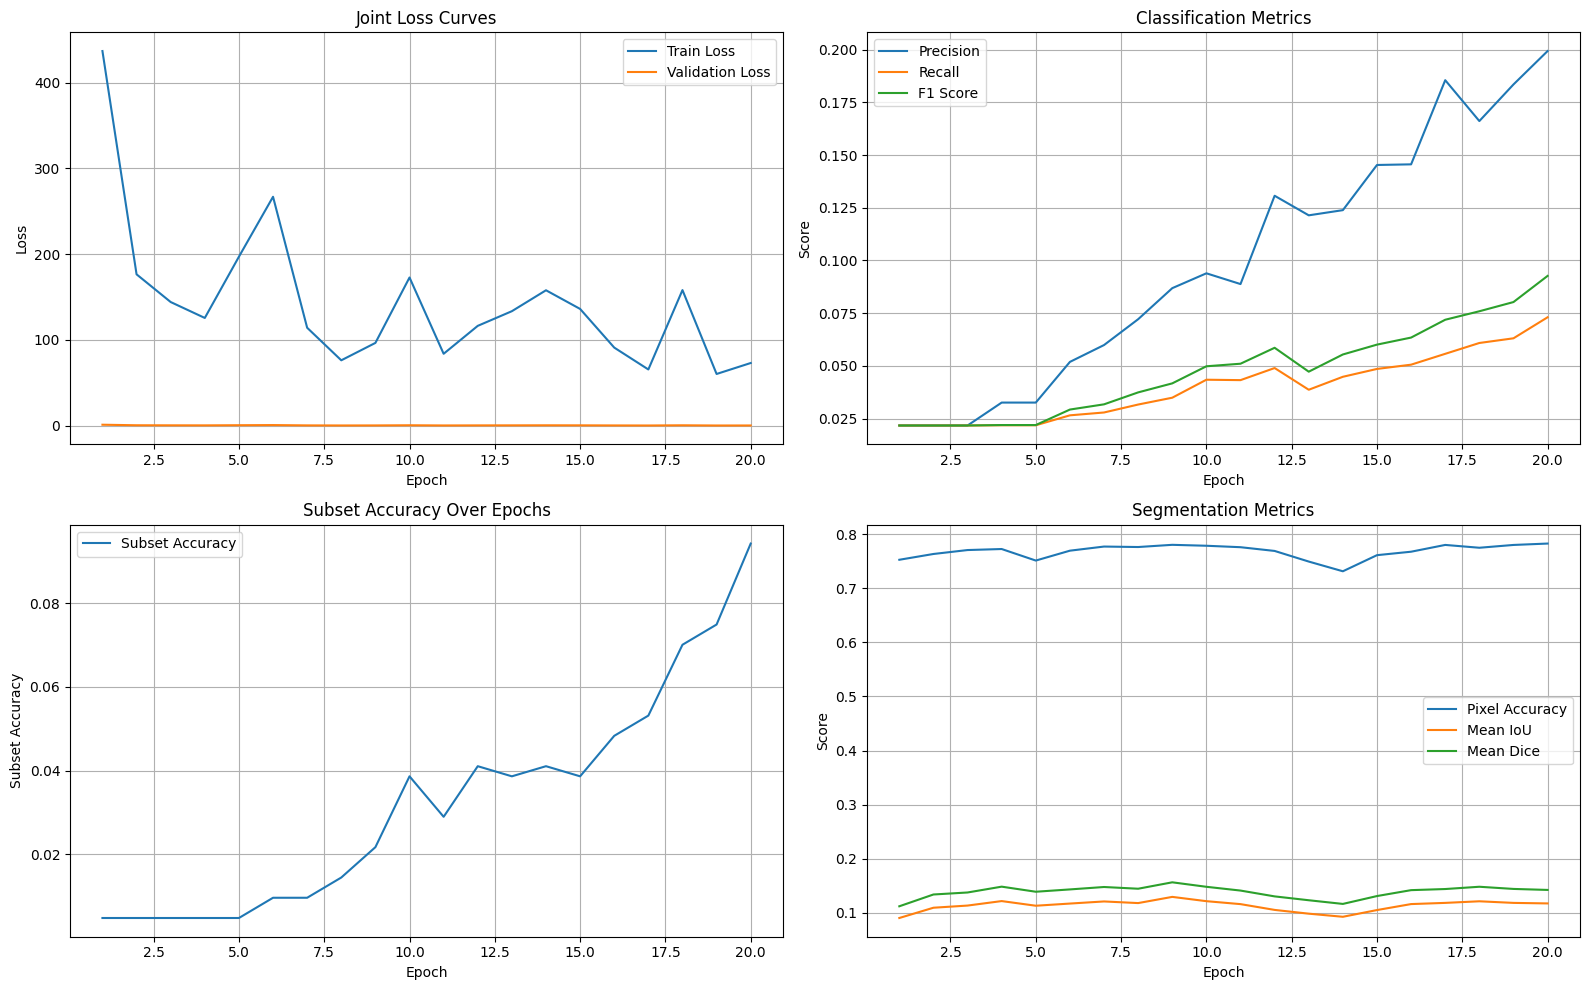

In [19]:
import numpy as np

import matplotlib.pyplot as plt

epochs = np.arange(1, len(train_losses) + 1)

plt.figure(figsize=(16, 10))

# Loss curves
plt.subplot(2, 2, 1)
plt.plot(epochs, train_losses, label="Train Loss")
plt.plot(epochs, val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Joint Loss Curves")
plt.legend()
plt.grid(True)

# Classification metrics
plt.subplot(2, 2, 2)
plt.plot(epochs, precisions, label="Precision")
plt.plot(epochs, recalls, label="Recall")
plt.plot(epochs, f1_scores, label="F1 Score")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.title("Classification Metrics")
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 3)
plt.plot(epochs, subset_accs, label="Subset Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Subset Accuracy")
plt.title("Subset Accuracy Over Epochs")
plt.legend()
plt.grid(True)

# Segmentation metrics
plt.subplot(2, 2, 4)
plt.plot(epochs, pixel_accs, label="Pixel Accuracy")
mean_ious = [np.nanmean(iou) for iou in ious_list]
mean_dices = [np.nanmean(dice) for dice in dice_list]
plt.plot(epochs, mean_ious, label="Mean IoU")
plt.plot(epochs, mean_dices, label="Mean Dice")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.title("Segmentation Metrics")
plt.legend()
plt.grid(True)
    
plt.tight_layout()
plt.show()

In [20]:
print("Classification Metrics:")
print(f"Mean Precision:  {np.mean(precisions):.4f}")
print(f"Mean Recall:     {np.mean(recalls):.4f}")
print(f"Mean F1:         {np.mean(f1_scores):.4f}")
print(f"Mean Subset Acc: {np.mean(subset_accs):.4f}")

mean_pixel_acc = np.mean(pixel_accs)
mean_ious = np.nanmean(np.array(ious_list), axis=0)
mean_iou_score = np.nanmean(mean_ious)
mean_dice = np.nanmean(np.array(dice_list), axis=0)
mean_dice_score = np.nanmean(mean_dice)

print("\nSegmentation Metrics:")
print(f"Pixel Accuracy: {mean_pixel_acc:.4f}")
print(f"Mean IoU: {mean_iou_score:.4f}")
print(f"Mean Dice Score: {mean_dice_score:.4f}")

Classification Metrics:
Mean Precision:  0.0993
Mean Recall:     0.0401
Mean F1:         0.0478
Mean Subset Acc: 0.0324

Segmentation Metrics:
Pixel Accuracy: 0.7680
Mean IoU: 0.1054
Mean Dice Score: 0.1291


/var/folders/qv/8ghds0hx12s2tw7v8qcq17580000gn/T/ipykernel_79204/2569216036.py:8: RuntimeWarning: Mean of empty slice
  mean_ious = np.nanmean(np.array(ious_list), axis=0)
/var/folders/qv/8ghds0hx12s2tw7v8qcq17580000gn/T/ipykernel_79204/2569216036.py:10: RuntimeWarning: Mean of empty slice
  mean_dice = np.nanmean(np.array(dice_list), axis=0)


**Multi-Task Model Results Summary**

**Classification Performance:**
- The model struggles to accurately predict ingredient labels in multi-label food images.
- Precision and recall are low, indicating frequent false positives and missed true ingredients.
- The F1 score remains modest, reflecting poor balance between precision and recall.
- Subset accuracy is very low, meaning the model rarely predicts all ingredients in an image exactly.

**Segmentation Performance:**
- Pixel accuracy is relatively high, but this is mostly due to correct predictions of dominant/background classes.
- Mean IoU and Dice scores are low, showing limited overlap and segmentation quality for less frequent ingredient classes.

**Conclusion:**  
The multi-task model tends to favor common classes and background, resulting in limited performance for both ingredient classification and segmentation, especially for rare classes. Further improvements are needed for better multi-label and fine-grained segmentation.


#### 5.4 Prediction Examples

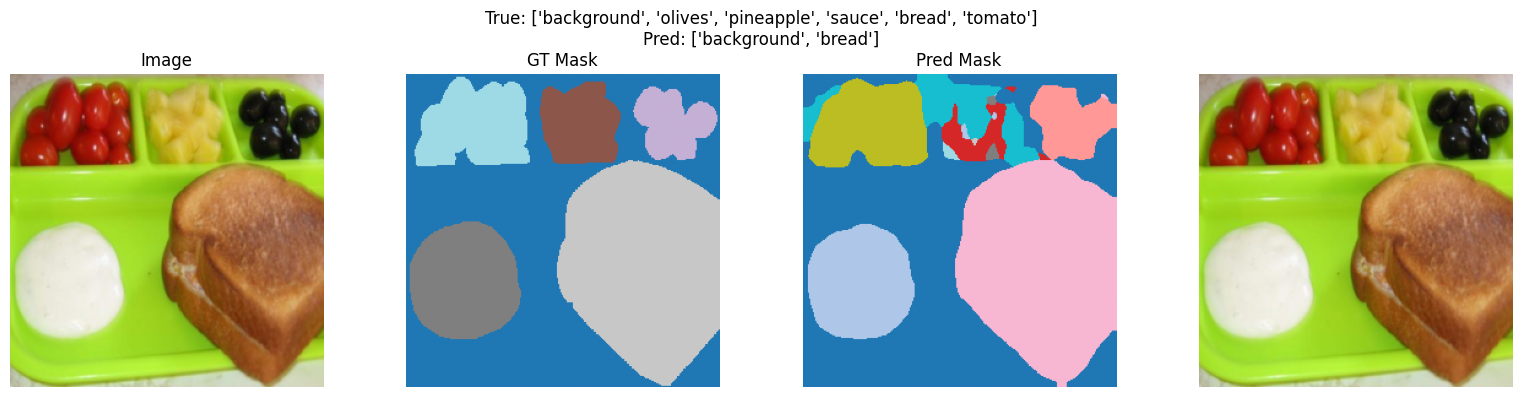

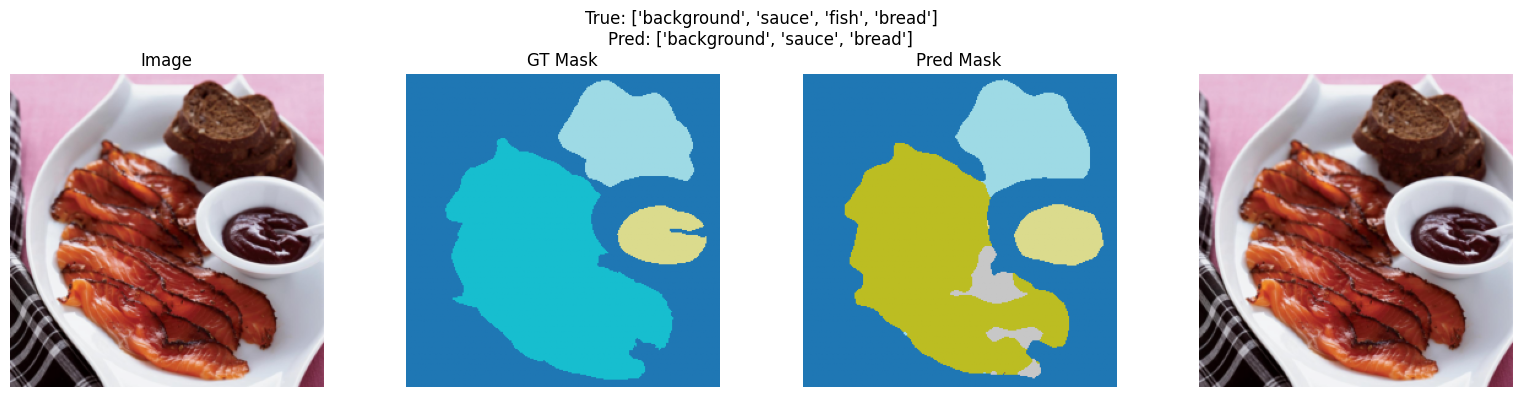

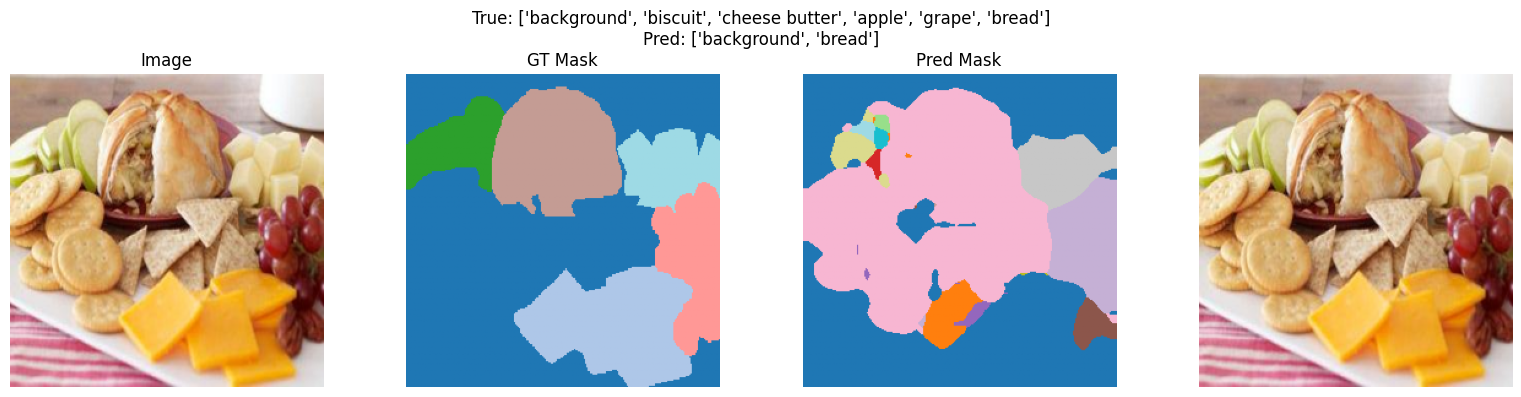

In [21]:
num_display = 3
model.eval()

batch = next(iter(val_loader))
images = batch["image"].to(device)
cls_targets = batch["ingredient_vector"].cpu().numpy()
seg_targets = batch["label"].cpu().numpy()

with torch.no_grad():
    cls_logits, seg_logits = model(images)
    cls_probs = torch.sigmoid(cls_logits).cpu().numpy()
    cls_preds = (cls_probs > 0.5).astype(int)
    seg_preds = torch.argmax(seg_logits, dim=1).cpu().numpy()

for i in range(num_display):
    img = images[i].cpu().permute(1, 2, 0).numpy()
    img = (img * [0.229, 0.224, 0.225]) + [0.485, 0.456, 0.406]
    img = img.clip(0, 1)

    true_cls_indices = np.where(cls_targets[i] == 1)[0]
    pred_cls_indices = np.where(cls_preds[i] == 1)[0]
    true_cls_labels = [label_list[k] for k in true_cls_indices]
    pred_cls_labels = [label_list[k] for k in pred_cls_indices]

    gt_mask = seg_targets[i]
    pred_mask = seg_preds[i]

    # Squeeze gt_mask if it has shape (1, H, W)
    if gt_mask.ndim == 3 and gt_mask.shape[0] == 1:
        gt_mask = gt_mask.squeeze(0)

    fig, axs = plt.subplots(1, 4, figsize=(16, 4))
    axs[0].imshow(img)
    axs[0].set_title("Image")
    axs[1].imshow(gt_mask, cmap='tab20')
    axs[1].set_title("GT Mask")
    axs[2].imshow(pred_mask, cmap='tab20')
    axs[2].set_title("Pred Mask")
    axs[3].imshow(img)
    fig.suptitle(f"True: {true_cls_labels}\nPred: {pred_cls_labels}")
    for ax in axs:
        ax.axis('off')
    plt.tight_layout()
    plt.show()